In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

import wandb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.crop_and_pad_transforms import CenterCropTransform
from batchgenerators.transforms.utility_transforms import NumpyToTensor
from torch.utils.data import DataLoader
from data_utils import get_eval_data
from dataset import MultisiteMRIProstateDataset
from model.unet import get_unet
from losses import DiceScorePMRI
from utils import epoch_average
from monai.metrics import DiceMetric
from omegaconf import OmegaConf
from pathlib import Path
from typing import Dict

In [2]:
test_vendors = ['philips', 'ge']

LOG = False
ITERATION = 0
DATA_KEY = 'prostate'
# VENDOR = test_vendors[0]
VENDOR = 'siemens'
LOAD_ONLY_PRESENT = False
extra_description = ''

cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', ITERATION)
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
cfg.unet[DATA_KEY].training.vendor = VENDOR
cfg.unet[DATA_KEY].training.load_only_present = LOAD_ONLY_PRESENT
cfg.wandb.project = f'{DATA_KEY}_{unet_name}_{ITERATION}{extra_description}'
cfg.wandb.log = LOG
# Set cfg.format to "numpy" for evaluation, otherwise don't modify it or set to "torch" for training
cfg.format = 'numpy'
cfg.unet[DATA_KEY].training.subset = True # Applies for evaluation dataset only

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

if LOG:
    wandb.init(
        project=cfg.wandb.project,
        config={
            "learning_rate": cfg.unet[DATA_KEY].training.lr,
            "architecture": unet_name,
            "dataset": DATA_KEY
        }
    )

In [3]:
unet, state_dict = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device);

In [3]:
# pmri_data_path = Path('/data/Data/PMRI').resolve()
# data_train = MultisiteMRIProstateDataset(pmri_data_path, 'siemens', 'train', load_only_present=False)
# data_valid = MultisiteMRIProstateDataset(pmri_data_path, 'siemens', 'valid', load_only_present=False)
# data_test = MultisiteMRIProstateDataset(pmri_data_path, 'philips', 'all', load_only_present=False)
# len(data_train), len(data_valid), len(data_test)

(1955, 445, 966)

In [4]:
data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
eval_dataset = data['eval']
print(len(eval_dataset))

Loading evaluation PMRI dataset...


445


In [15]:
b = DiceMetric()
d = DataLoader(eval_dataset, batch_size=8, shuffle=False, drop_last=False)

In [17]:
batch = None
for ba in d:
    batch = ba
    break
print(batch['input'].shape)

torch.Size([8, 1, 256, 256])


In [18]:
img = batch['input'][0]
img.shape

torch.Size([1, 256, 256])

In [ ]:
plt.imshow(batch['input'][0])

In [12]:
def eval_set(cfg, model, dataset):
    if cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=16,
                                shuffle=False, drop_last=False)

        eval_metrics = {
            "Dice Score": DiceMetric()
        }

        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    else:
        raise ValueError(
            f'Invalid data key. No config for dataset named {cfg.run.data_key}'
        )
    return metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input'] # .float()
        target = batch['target'] # .long()
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            print(out.shape)
            print(target.shape)
            computed_metric = metric(out, target).detach().mean().cpu()
            epoch_metrics[key].append(metric(out, target).detach().mean().cpu())

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    return epoch_metrics

def get_df_from_dict(cfg, metrics: Dict):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key
    return df


torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 2, 256, 256])
torch.Size

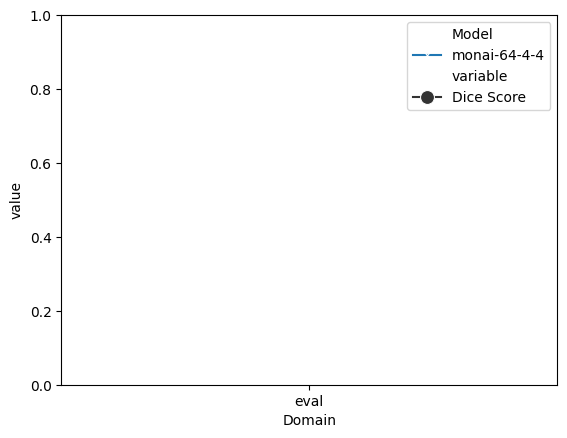

In [13]:
metrics = {}

for key in data.keys():
    metrics[key] = eval_set(
        cfg=cfg,
        model=unet,
        dataset=data[key]
    )

df = get_df_from_dict(cfg, metrics)

sns.lineplot(
    data=df, 
    x='Domain', 
    y='value', 
    hue='Model',
    style='variable',
    markers=True, 
    dashes=False, 
    markersize=10, 
    marker='x'
)

plt.show()